In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Read in data:

In [2]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
av     = xr.open_dataset('averages_00031502.nc', decode_times=False)  #5-day average

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.125deg_N15_baseline
# fs=xr.open_dataset('static.nc', decode_times=False)
# os=xr.open_dataset('ocean.stats.nc', decode_times=False)
# av     = xr.open_dataset('averages_00004502.nc', decode_times=False)  #5-day average

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline
# fs=xr.open_dataset('static.nc', decode_times=False)
# os=xr.open_dataset('ocean.stats.nc', decode_times=False)
# av     = xr.open_dataset('averages_00006002.nc', decode_times=False)  #5-day average

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline
# fs=xr.open_dataset('static.nc', decode_times=False)
# os=xr.open_dataset('ocean.stats.nc', decode_times=False)
# av     = xr.open_dataset('averages_00001402.nc', decode_times=False)  #5-day average




%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake/




/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/Vertical_Structure_with_Jake


In [3]:
print(fs)

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * time         (time) float64 0.0
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables:
    geolon       (yh, xh) float64 ...
    geolat       (yh, xh) float64 ...
    geolon_c     (yq, xq) float32 ...
    geolat_c     (yq, xq) float32 ...
    geolon_u     (yh, xq) float32 ...
    geolat_u     (yh, xq) float32 ...
    geolon_v     (yq, xh) float32 ...
    geolat_v     (yq, xh) float32 ...
    area_t       (yh, xh) float64 ...
    area_u       (yh, xq) float64 ...
    area_v       (yq, xh) float64 ...
    dyCu         (yh, xq) float64 ...
    dxCv         (yq, xh) float64 ...
    dxCu         (yh, xq) float64 ...
    dyCv     

In [13]:
coriolis = fs.Coriolis
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
coriolis = grid.interp(coriolis,axis='Y')
coriolis = grid.interp(coriolis,axis='X')
print(coriolis.shape)

(560, 240)


In [14]:
xh= fs.xh.values
yh = fs.yh.values
Nlayers=15
Depth=fs.depth_ocean

h  = av['h'].mean('time').fillna(0.)
#Replace thin layers with nan:
h = h.where(h >.1) 

rho = os.Interface
rho = rho.Interface.rename({'Interface': 'zl'})
drho = rho.diff('zl')
drho=  drho.assign_coords(zl=h.zl)

drhodz=drho/h

N = (((10*drhodz/1022.5)**0.5)*h/h.sum('zl')).sum('zl')

f_N=coriolis/N
print(f_N.shape)

(560, 240)


In [15]:
print(N.shape)

(560, 240)


In [16]:
import scipy.io
f_N_025=f_N
scipy.io.savemat('f_N_025.mat', mdict={'xh':xh,
                                               'yh':yh,
                                               'f_N':f_N_025})


In [17]:
print('done')

done


/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


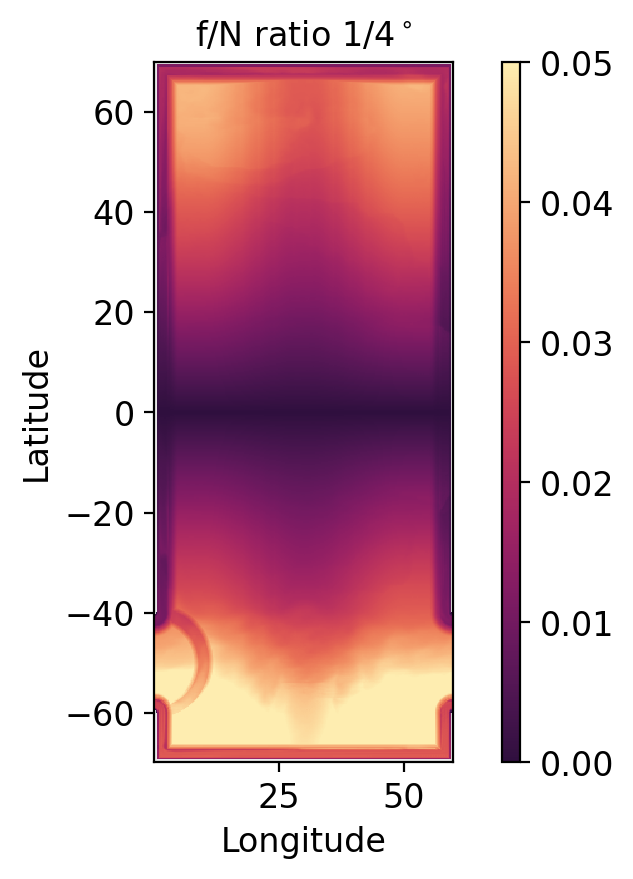

In [19]:
fig = plt.figure(figsize=(3, 5), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('f/N ratio 1/4$^\circ$',fontsize=12)
ax1.set_xlabel('Longitude',fontsize=12)
ax1.set_ylabel('Latitude',fontsize=12)
ax1.tick_params(labelsize=12); 
ax2.tick_params(labelsize=12)

#levels=np.linspace(0.,.05,51) #not logarithmic colormap
levels=np.linspace(0,1000,111)
plotted =ax1.pcolor(xh,yh,abs(f_N),cmap=cmocean.cm.matter_r,vmin=0,vmax=0.05)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#
plt.show()

Text(0.5, 1.0, '1/4$^\\circ$ f/N')

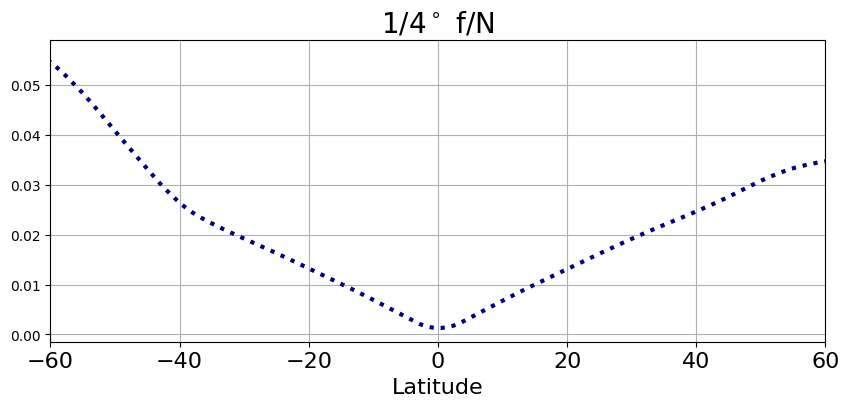

In [21]:
window=30

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)

plt.plot(yh,np.convolve((abs(f_N[:,10:-10])).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
#plt.plot(yh,np.convolve((abs(f_N[:,470:490])).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)

#plt.plot(yh_00625,np.convolve((fraction_BT_eddy_00625).mean('xh')/(fraction_BC_eddy_00625).mean('xh').compute(), np.ones((window,))/window, mode='same'),':',c=[0,0,0.5],linewidth=3)
plt.grid()

#plt.plot([0, 0],[0, 6],'-',color=[0,0,0])
plt.xlim(-60, 60); plt.xticks(fontsize=16);
#plt.ylim(0,.02); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
plt.title('1/4$^\circ$ f/N',fontsize=20)